In [4]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib as mlp
import matplotlib.pyplot as plt
import japanize_matplotlib
import math

In [5]:
def agg_data_for_unit():
    data_sets = pd.DataFrame()
    beacon_files = os.listdir('raw_data/')
    pos_files = os.listdir('POS_RAW_data/')

    beacon_files.sort()
    pos_files.sort()
    
    if beacon_files[0] == ".DS_Store":
        beacon_files.pop(0)

    if pos_files[0] == ".DS_Store":
        pos_files.pop(0)

    pos_files = list(map(lambda x: x[:14], pos_files))[::2]

    for beacon_file, pos_file in zip(beacon_files, pos_files):
        date_beacon = beacon_file[9:17]
        date_pos    = pos_file[6:14]

        if date_beacon != date_pos:
            continue
        else:
            date = date_beacon
        
        t_start = datetime.strptime(f'{date} 09:00', '%Y%m%d %H:%M').timestamp()
        t_end   = datetime.strptime(f'{date} 21:00', '%Y%m%d %H:%M').timestamp()
        rssi    = 70
        beacon_data = pd.read_csv(f"raw_data/{beacon_file}")
        pos_data1 = pd.read_csv(f"POS_RAW_data/{pos_file}_01.csv")
        pos_data2 = pd.read_csv(f"POS_RAW_data/{pos_file}_02.csv")

        pos_data1 = pos_data1[["商品コード", "商品名称（または券名称）", "単価", "数量", "合計金額"]]
        pos_data2 = pos_data2[["商品コード", "商品名称（または券名称）", "単価", "数量", "合計金額"]]
        pos_data  = pd.concat([pos_data1, pos_data2])

        pos_data[["単価", "数量", "合計金額"]] = pos_data[["単価", "数量", "合計金額"]].map(lambda x: int(x))
        pos_data = pos_data.groupby(["商品コード", "商品名称（または券名称）"]).sum()

        pos_data["単価"] = pos_data["合計金額"] / pos_data["数量"]
        pos_data["単価"] = pos_data["単価"].astype(int)

        beacon_data.columns = ["No.", "mac-address", "distance", "rssi", "random", "timestamp"]
        beacon_data = beacon_data[beacon_data["random"] == 1]
        beacon_data = beacon_data[beacon_data["timestamp"] >= t_start]
        beacon_data = beacon_data[beacon_data["timestamp"] <= t_end]
        beacon_data = beacon_data[beacon_data["rssi"] < rssi]
        beacon_data = beacon_data.drop_duplicates("mac-address")

        per_unit = pd.DataFrame(
            {
                "date":[date],
                "総ビーコン数": [len(beacon_data)],
                "総売上点数": [pos_data["数量"].sum()],
                "総売上": [pos_data["合計金額"].sum()],
            }
        )
        data_sets = pd.concat([data_sets, per_unit])

    return data_sets.reset_index(drop=True)

In [6]:
def calc_standard_deviation(real_y, mean_y):
    tmp_y = (real_y - mean_y) ** 2
    tmp_y = tmp_y.sum() / len(tmp_y)
    tmp_y = np.sqrt(tmp_y)
    return tmp_y

正解率(train):0.505
正解率(test):0.506
標準偏差σ:23.831
3σ:71.492


/opt/homebrew/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PoissonRegressor was fitted with feature names
  warnings.warn(


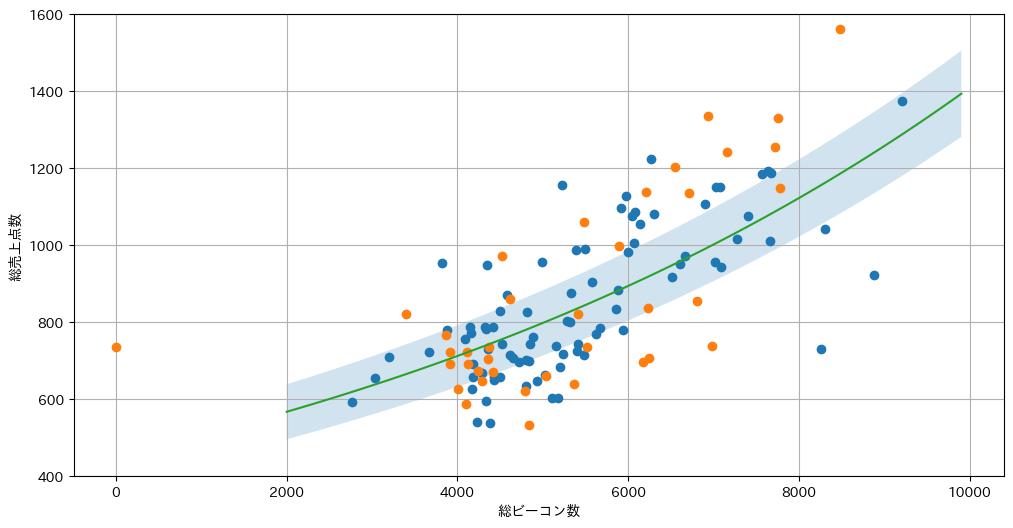

In [7]:
from sklearn.linear_model import PoissonRegressor

data_sets = agg_data_for_unit()

X = data_sets.drop(["date", "総売上点数", "総売上"], axis=1)
y = data_sets["総売上点数"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#sc = StandardScaler()
#sc.fit(X_train)
#X_train_std = sc.transform(X_train)
#X_test_std  = sc.transform(X_test)

model = PoissonRegressor(solver="newton-cholesky")
model.fit(X_train, y_train)

print("正解率(train):{:.3f}".format(model.score(X_train, y_train)))
print("正解率(test):{:.3f}".format(model.score(X_test, y_test)))

x = np.arange(2000, 10000, 100)
x = x.reshape(len(x), 1)

mean = model.predict(x)
var  = np.sqrt(mean)

print("標準偏差σ:{:.3f}".format(var[0]))
print("3σ:{:.3f}".format(3*var[0]))

plt.figure(figsize=(12, 6))

plt.plot(X_train, y_train, "o")
plt.plot(X_test, y_test, "o")
plt.plot(x, mean, "-")
plt.fill_between(x.reshape(len(x)), mean - 3*var, mean + 3*var, alpha=0.2)
plt.xlabel("総ビーコン数")
plt.ylabel("総売上点数")
plt.ylim(400, 1600)
plt.grid(True)

理論上の標準偏差： 27.469101489649386
実際の標準偏差: 101.87408349962658


/opt/homebrew/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PoissonRegressor was fitted with feature names
  warnings.warn(


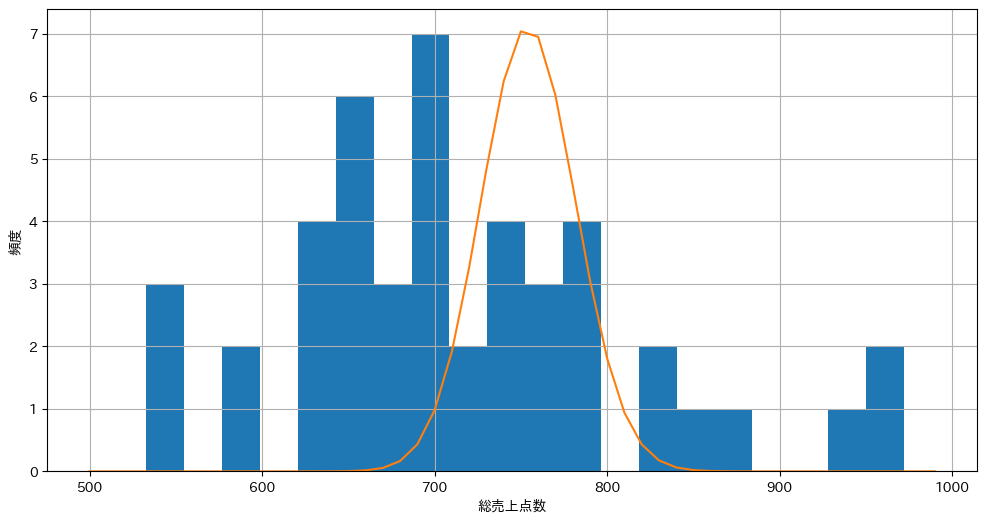

In [8]:
def poisson(lambda_, k):
    tmp = 1.0
    if lambda_ > k:
        for ite in range(1, int(k)+1):
            tmp = tmp * (lambda_ / ite) / math.e

        tmp = tmp * np.exp(k - lambda_)
    else:
        n = round(lambda_)
        for ite in range(1, n):
            tmp = tmp * (lambda_ / ite) / math.e
        for ite in range(n, int(k)+1):
            tmp = tmp * (lambda_ / ite)
        tmp = tmp * np.exp((n - 1) - lambda_)
    return tmp

datasets_tmp = data_sets[(4000 < data_sets["総ビーコン数"]) & (data_sets["総ビーコン数"] < 5000)]
mean = model.predict([[4500],])[0]
y = datasets_tmp["総売上点数"]

x = np.arange(500, 1000, 10)
x = x.reshape(len(x))
poisson_y = list(map(lambda x_: poisson(mean, x_) * (np.max(x) - np.min(x)), x))

plt.figure(figsize=(12, 6))

plt.hist(y, bins=20)
plt.plot(x, poisson_y, "-")
plt.xlabel("総売上点数")
plt.ylabel("頻度")
plt.grid(True)


print("理論上の標準偏差：", np.sqrt(mean))
print("実際の標準偏差:", calc_standard_deviation(y, y.mean()))

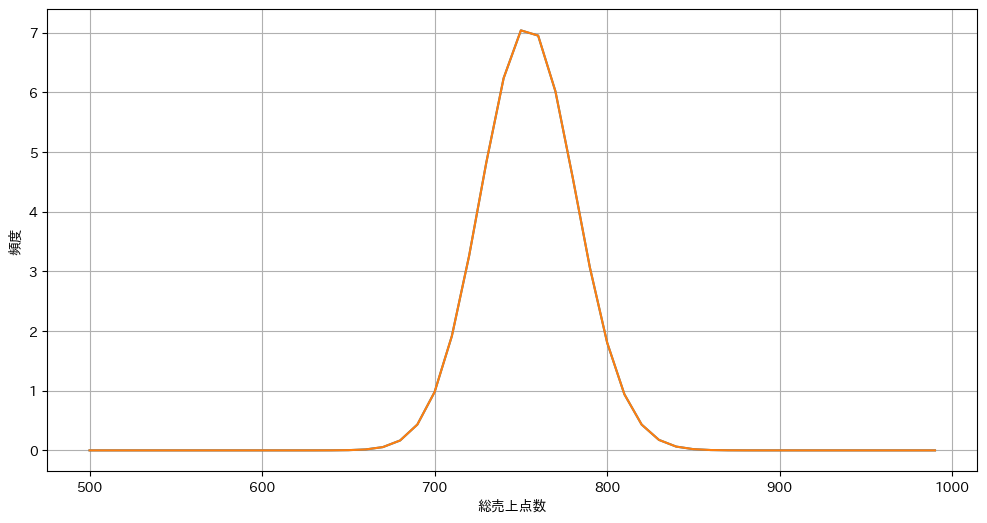

In [9]:
from scipy.stats import poisson

def my_poisson(lambda_, k):
    tmp = 1.0
    if lambda_ > k:
        for ite in range(1, int(k)+1):
            tmp = tmp * (lambda_ / ite) / math.e

        tmp = tmp * np.exp(k - lambda_)
    else:
        n = round(lambda_)
        for ite in range(1, n):
            tmp = tmp * (lambda_ / ite) / math.e
        for ite in range(n, int(k)+1):
            tmp = tmp * (lambda_ / ite)
        tmp = tmp * np.exp((n - 1) - lambda_)
    return tmp



x = np.arange(500, 1000, 10)
x = x.reshape(len(x))
my_poisson_y = list(map(lambda x_: my_poisson(mean, x_) * (np.max(x) - np.min(x)), x))
poisson_y    = list(map(lambda x_: poisson.pmf(x_, mean) * (np.max(x) - np.min(x)), x))


plt.figure(figsize=(12, 6))

plt.plot(x, my_poisson_y, "-")
plt.plot(x, poisson_y, "-")
plt.xlabel("総売上点数")
plt.ylabel("頻度")
plt.grid(True)